# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import time
from dqn_agent import Agent
from collections import deque
import torch
import matplotlib.pyplot as plt
%matplotlib inline

### 2 Load the environment

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64\Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 3. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 4. Test Environment by taking random actions

Next cell show how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, we will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment. 

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


### 5. Train the Agent with the DQN algorithm!

Firts we will define the training function. This function recieves as input parameters:

    - `agent`: The agent to be trained.
    - `n_episodes`: The number of episodes to train the agent.
    - `eps_start`: The initial value of epsilon.
    - `eps_decay`: The decay rate of epsilon.

This function saves the agent's neuronal network weights in a file called `checkpoint.pth` and returns a log of the scores obtained along the training process.

In [5]:
def dqn(agent, n_episodes=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    timer_window = deque(maxlen=100)    # last 100 episode timers 
    eps = eps_start                    # initialize epsilon
    start_time = time.time()
    for i_episode in range(1, n_episodes+1):
        timer = time.time()
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        while True:
            action = int(agent.act(state, eps))
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]                   
            done = env_info.local_done[0]                  
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                timer = time.time()-timer
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        timer_window.append(timer)        # save most recent timer
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tAverage time: {:.2f}'.format(i_episode, 
                                                                                    np.mean(scores_window),
                                                                                    np.mean(timer_window)))
        if np.mean(scores_window)>=16:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}\tTraining time: {:.2f}'.format(i_episode-100,
                                                                                                            np.mean(scores_window),                                                                                                                    time.time()-start_time))
            break
    torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
    return scores

After we have the training function, we have to instantiate the agent and pass it as input to the training function. For this training we are going to use the default hyperparameters of the training function.

In [6]:

agent = Agent(state_size=37, action_size=4, seed=0)
scores = dqn(agent) 

cuda:0
Episode 100	Average Score: 0.67	Average time: 1.80
Episode 200	Average Score: 4.55	Average time: 1.64
Episode 300	Average Score: 7.08	Average time: 1.63
Episode 400	Average Score: 9.67	Average time: 1.65
Episode 500	Average Score: 12.58	Average time: 1.66
Episode 600	Average Score: 13.92	Average time: 1.66
Episode 700	Average Score: 14.40	Average time: 1.66
Episode 800	Average Score: 15.51	Average time: 1.68
Episode 900	Average Score: 15.75	Average time: 1.60
Episode 1000	Average Score: 15.47	Average time: 1.60
Episode 1047	Average Score: 16.02
Environment solved in 947 episodes!	Average Score: 16.02	Training time: 1734.69


Let's plot the progress of our agent along it's training process

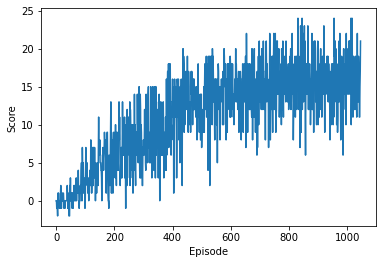

In [7]:
fig = plt.figure()
plt.plot(np.arange(len(scores)),scores)
plt.ylabel("Score")
plt.xlabel("Episode")
plt.show()

### 6 Watch Smart Agent play in the current environment.

After having a trained agent, its weights are stored in `checkpoint.pth`. We can load this weights to watch the smart agent play as shown in the next cell. 

In [8]:

NUMBER_OF_EPISODES = 4

#Instantiate untrained agent
agent = Agent(state_size=37, action_size=4, seed=0)
#Load weights form file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(NUMBER_OF_EPISODES):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    score = 0
    while True:
        action = agent.act(state)
        env_info = env.step(int(action))[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        score += reward
        state = next_state
        if done:
            break
    if score >= 13:
        print("Congratulations your score is {}".format(score))
    else:
        print("Buh! you only scored {}. Try again".format(score))


cuda:0
Congratulations your score is 17.0
Buh! you only scored 11.0. Try again
Congratulations your score is 17.0
Congratulations your score is 15.0


After all, let's close the environment.

In [9]:
env.close()